In [1]:
import sys
import os
import getpass

# Path to where your CaloQVAE dir is
upper_dir = 'SPVAE'
# Path to where your CaloQVAE dir is
os.chdir('/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}/')

#external libraries
import os

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())

In [2]:
import h5py
import torch

def load_hdf5_as_tensors(file_path):
    """
    读取HDF5文件中 "showers" 和 "incidence energy" 数据集,并将其转换为PyTorch tensor。

    参数:
    file_path (str): HDF5文件的路径

    返回:
    showers_tensor (torch.Tensor): "showers" 数据集的 PyTorch tensor
    energy_tensor (torch.Tensor): "incidence energy" 数据集的 PyTorch tensor
    """
    try:
        with h5py.File(file_path, 'r') as hdf:
            # 读取"showers"数据集
            showers_data = hdf["showers"][:]
            # showers_data = hdf["energies"][:]
            # 读取"incidence energy"数据集
            # energy_data = hdf["incidence energy"][:]
            energy_data = hdf["incident_energies"][:]

            # 转换为PyTorch tensor
            showers_tensor = torch.tensor(showers_data, dtype=torch.float32)
            # energy_tensor = torch.tensor(energy_data)

            # print("数据已成功转换为 PyTorch tensor。")
            return showers_tensor, energy_data
            # , energy_tensor
    except KeyError as e:
        print(f"找不到数据集: {e}")
    except Exception as e:
        print(f"发生错误: {e}")

def load_hdf5_as_tensors_gen(file_path):
    """
    读取HDF5文件中 "showers" 和 "incidence energy" 数据集,并将其转换为PyTorch tensor。

    参数:
    file_path (str): HDF5文件的路径

    返回:
    showers_tensor (torch.Tensor): "showers" 数据集的 PyTorch tensor
    energy_tensor (torch.Tensor): "incidence energy" 数据集的 PyTorch tensor
    """
    try:
        with h5py.File(file_path, 'r') as hdf:
            # 读取"showers"数据集
            showers_data = hdf["showers"][:]
            # showers_data = hdf["energies"][:]
            # 读取"incidence energy"数据集
            # energy_data = hdf["incidence energy"][:]
            energy_data = hdf["incidence energy"][:]

            # 转换为PyTorch tensor
            showers_tensor = torch.tensor(showers_data, dtype=torch.float32)
            # energy_tensor = torch.tensor(energy_data)

            # print("数据已成功转换为 PyTorch tensor。")
            return showers_tensor, energy_data
            # , energy_tensor
    except KeyError as e:
        print(f"找不到数据集: {e}")
    except Exception as e:
        print(f"发生错误: {e}")


def list_top_level_groups_datasets(file_path):
    """
    列出HDF5文件中顶层的组和数据集。

    参数:
    file_path (str): HDF5文件的路径
    """
    with h5py.File(file_path, 'r') as hdf:
        print("顶层组和数据集:")
        for key in hdf.keys():
            if isinstance(hdf[key], h5py.Group):
                print(f"{key} - Group")
            elif isinstance(hdf[key], h5py.Dataset):
                print(f"{key} - Dataset")


In [12]:

# diffusion_path_test = "/fast_scratch_1/caloqvae/calodiffusion/calorimeter_evaluation_data/old_dataset/dataset_2_electron_CaloDiffusion.h5"
test_data_3d_nhd_ori = "/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_robust-serenity-216en150.hdf5"
test_data_no_hit_mask = "/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_polar-moon-405-latest.hdf5"
target_path = "/fast_scratch_1/caloqvae/test_data/dataset_2_2.hdf5"
# file_path_test = "/fast_scratch_1/caloqvae/test_data/dataset_2_2.hdf5"


In [13]:
test_data_3d_nhd_ori_samples, energies = load_hdf5_as_tensors_gen(test_data_3d_nhd_ori)
test_data_no_hit_mask_samples, energies = load_hdf5_as_tensors_gen(test_data_no_hit_mask)
target_samples, energies = load_hdf5_as_tensors(target_path)


In [61]:
def _reduce(in_data, true_energy, R=1e-7):
        """
        CaloDiff Transformation Scheme
        """
        ϵ = in_data/true_energy
        x = R + (1-2*R)*ϵ
        u = u = torch.log(x*(1-R)/(R*(1-x))) #torch.log(torch.tensor([δ/(1-δ)]))
        return u

def _reduceinv(in_data, true_energy, R=1e-7):
        """
        CaloDiff Transformation Scheme
        """
        
        x = (torch.sigmoid(in_data + torch.log(torch.tensor([R/(1-R)]).to(in_data.device)) ) - R)/(1-2*R) * true_energy
        x[torch.isclose(x, torch.tensor([0]).to(dtype=x.dtype, device=x.device)) ] = 0.0
        
        return x
reduced_target = _reduce(target_samples, energies)
# / extended_layer_mask_matrix
reduced_test_data_3d_nhd_ori_samples = _reduce(test_data_3d_nhd_ori_samples, energies)
reduced_test_data_no_hit_mask_samples = _reduce(test_data_no_hit_mask_samples, energies)
# / extended_layer_mask_matrix

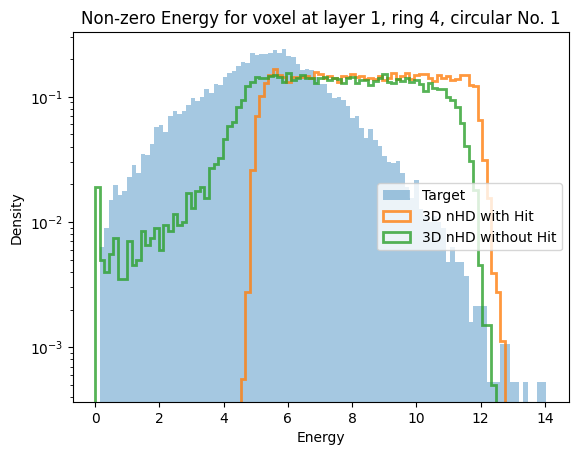

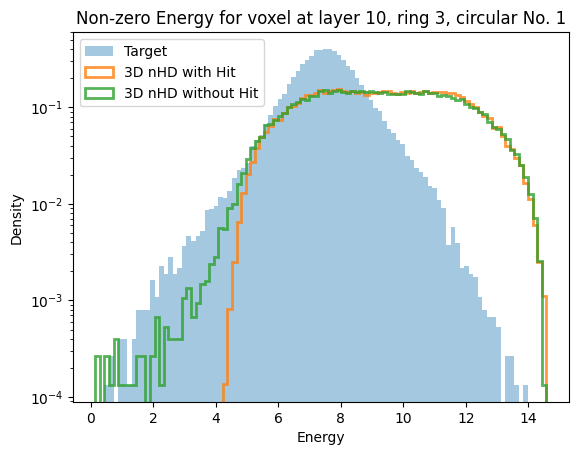

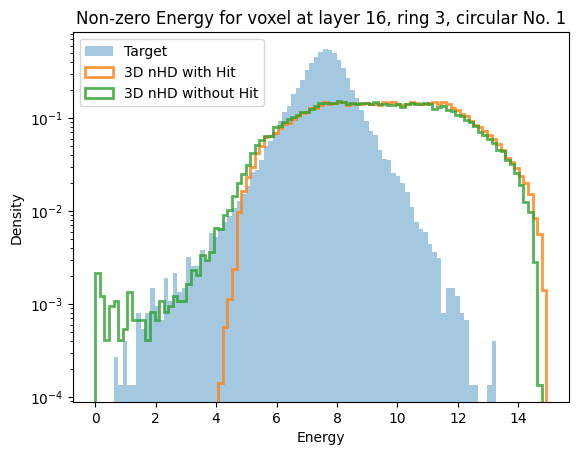

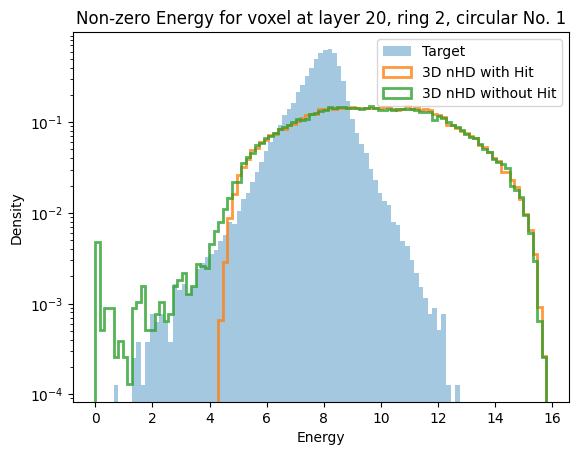

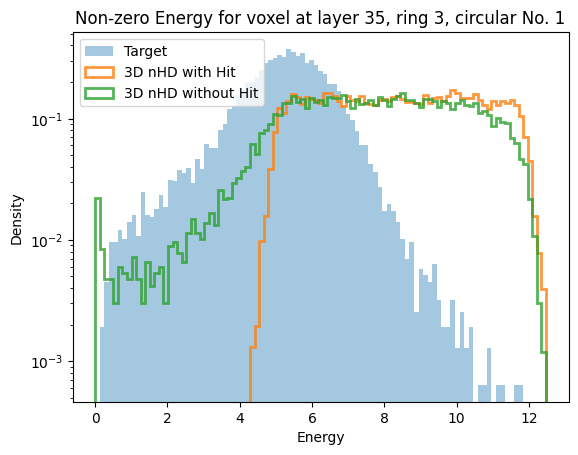

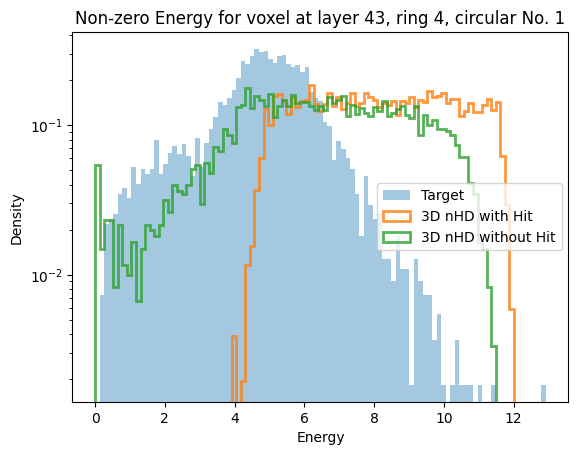

In [62]:
import numpy as np
import matplotlib.pyplot as plt
voxel_indexs = []
locs = [[1,4,1], [10,3,1],[16,3,1],[20,2,1], [35,3,1],[43, 4,1]]
# Assuming the necessary data has already been defined and loaded.
for loc in locs:
    n_layer, n_ring, n_s = loc
    voxel_index = (n_layer - 1) * 144 + (n_ring - 1) + (n_s - 1) * 9 
    target_voxel = reduced_target[:, voxel_index]
    reduced_test_data_3d_nhd_ori_samples_voxel = reduced_test_data_3d_nhd_ori_samples[:, voxel_index]
    reduced_test_data_no_hit_mask_samples_voxel = reduced_test_data_no_hit_mask_samples[:, voxel_index]

    non_zero_values_target = target_voxel[target_voxel != 0].numpy()
    non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel = reduced_test_data_3d_nhd_ori_samples_voxel[reduced_test_data_3d_nhd_ori_samples_voxel != 0].numpy()
    non_zero_values_reduced_test_data_no_hit_mask_samples_voxel = reduced_test_data_no_hit_mask_samples_voxel[reduced_test_data_no_hit_mask_samples_voxel != 0].numpy()

    n_bins = 50
    combined_bins_upper = max(max(non_zero_values_target), 
                            max(non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel), 
                            max(non_zero_values_reduced_test_data_no_hit_mask_samples_voxel))
    combined_bins_lower = min(min(non_zero_values_target), 
                            min(non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel), 
                            min(non_zero_values_reduced_test_data_no_hit_mask_samples_voxel))
    combined_bins = np.linspace(combined_bins_lower, combined_bins_upper, 100)

    # Plot filled histogram for the target
    plt.hist(non_zero_values_target, label='Target', alpha=0.4, bins=combined_bins, density=True)

    # Plot step histograms for the other two datasets
    plt.hist(non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel, 
            label='3D nHD with Hit', alpha=0.8, bins=combined_bins, 
            density=True, histtype='step', linewidth=2)

    plt.hist(non_zero_values_reduced_test_data_no_hit_mask_samples_voxel, 
            label='3D nHD without Hit', alpha=0.8, bins=combined_bins, 
            density=True, histtype='step', linewidth=2)

    # Add titles and labels
    plt.title(f'Non-zero Energy for voxel at layer {n_layer}, ring {n_ring}, circular No. {n_s}')
    plt.xlabel('Energy')
    plt.ylabel('Density')
    plt.yscale('log')

    plt.legend()
    plt.show()

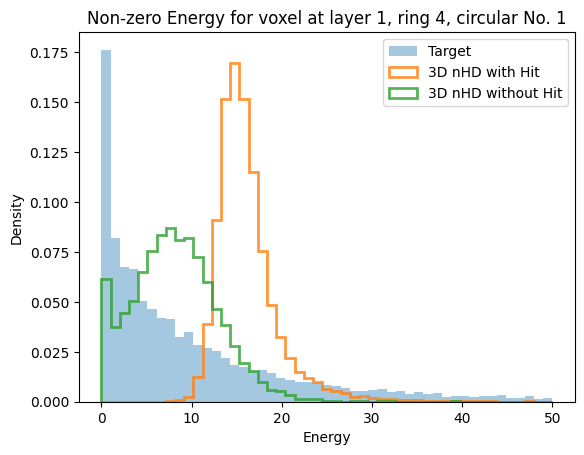

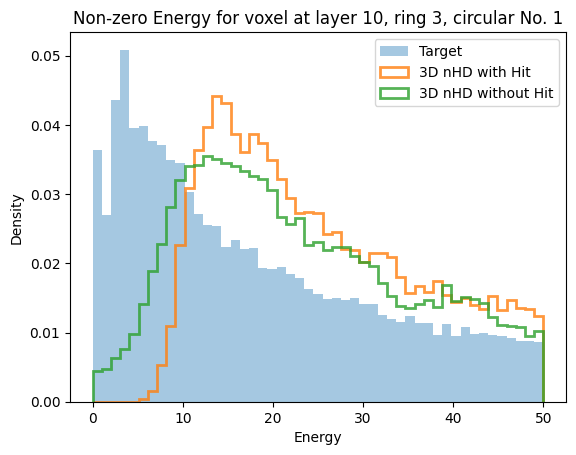

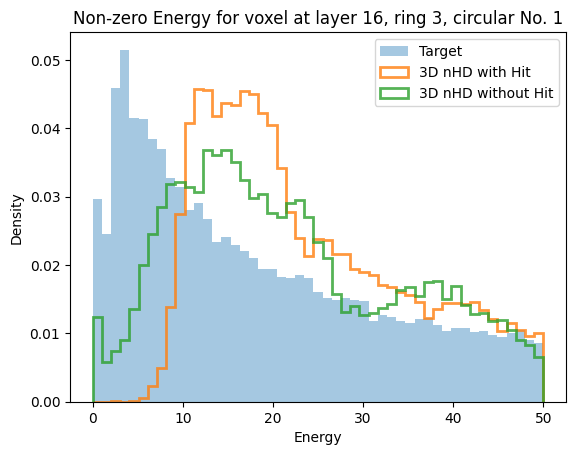

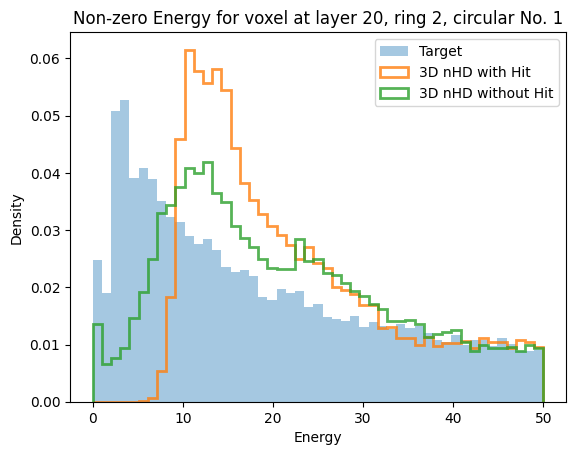

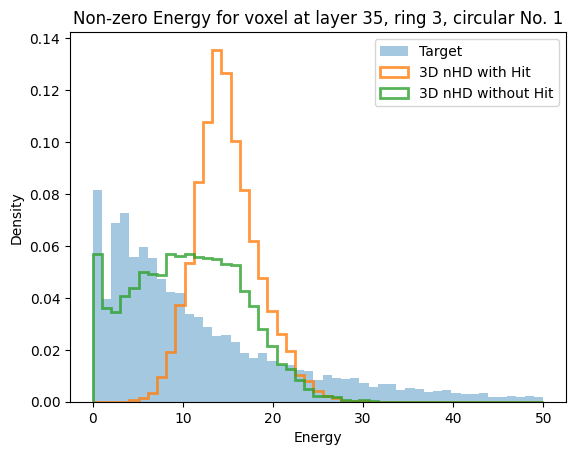

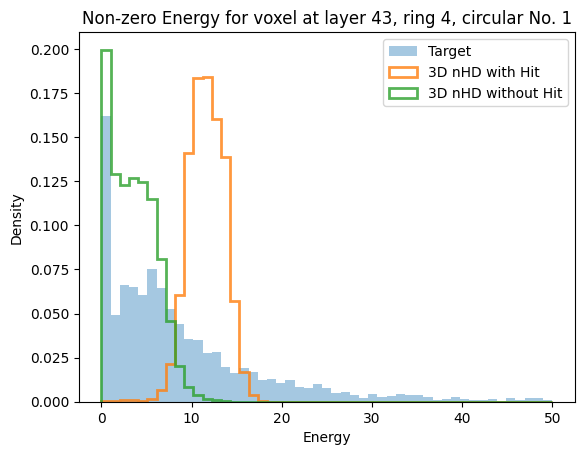

In [63]:
import numpy as np
import matplotlib.pyplot as plt
voxel_indexs = []
locs = [[1,4,1], [10,3,1],[16,3,1],[20,2,1], [35,3,1],[43, 4,1]]
# Assuming the necessary data has already been defined and loaded.
for loc in locs:
    n_layer, n_ring, n_s = loc
    voxel_index = (n_layer - 1) * 144 + (n_ring - 1) + (n_s - 1) * 9 
    target_voxel = target_samples[:, voxel_index]
    reduced_test_data_3d_nhd_ori_samples_voxel = test_data_3d_nhd_ori_samples[:, voxel_index]
    reduced_test_data_no_hit_mask_samples_voxel = test_data_no_hit_mask_samples[:, voxel_index]

    non_zero_values_target = target_voxel[target_voxel != 0].numpy()
    non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel = reduced_test_data_3d_nhd_ori_samples_voxel[reduced_test_data_3d_nhd_ori_samples_voxel != 0].numpy()
    non_zero_values_reduced_test_data_no_hit_mask_samples_voxel = reduced_test_data_no_hit_mask_samples_voxel[reduced_test_data_no_hit_mask_samples_voxel != 0].numpy()

#     n_bins = 50
#     combined_bins_upper = max(max(non_zero_values_target), 
#                             max(non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel), 
#                             max(non_zero_values_reduced_test_data_no_hit_mask_samples_voxel))
#     combined_bins_lower = min(min(non_zero_values_target), 
#                             min(non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel), 
#                             min(non_zero_values_reduced_test_data_no_hit_mask_samples_voxel))
#     combined_bins = np.linspace(combined_bins_lower, combined_bins_upper, 100)

    lim = [0, 50]
    combined_bins = np.linspace(lim[0], lim[1], n_bins)  # 分成 50 份，需要 51 个边界点

    # Plot filled histogram for the target
    plt.hist(non_zero_values_target, label='Target', alpha=0.4, bins=combined_bins, density=True)

    # Plot step histograms for the other two datasets
    plt.hist(non_zero_values_reduced_test_data_3d_nhd_ori_samples_voxel, 
            label='3D nHD with Hit', alpha=0.8, bins=combined_bins, 
            density=True, histtype='step', linewidth=2)

    plt.hist(non_zero_values_reduced_test_data_no_hit_mask_samples_voxel, 
            label='3D nHD without Hit', alpha=0.8, bins=combined_bins, 
            density=True, histtype='step', linewidth=2)

    # Add titles and labels
    plt.title(f'Non-zero Energy for voxel at layer {n_layer}, ring {n_ring}, circular No. {n_s}')
    plt.xlabel('Energy')
    plt.ylabel('Density')
#     plt.yscale('log')

    plt.legend()
    plt.show()